## **📈 Project Overview**

This project models the volatility of stock returns using a GARCH(1,1) model. Volatility clustering is a well-known phenomenon in financial time series, and GARCH models are widely used to capture this behavior for risk management, portfolio optimization, and derivative pricing.

**🛠 Step 1: Setup**

Make sure you install these Python libraries

In [6]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 22.2 MB/s eta 0:00:00


**🛠 Step 2: Fetch Stock Price Data**

We'll use yfinance to easily grab historical stock prices

We’ll pick:

*   TSLA (Tesla — high volatility)

*   AAPL (Apple — stable blue chip)

*   ^GSPC (S&P500 index — market benchmark)

In [9]:
import warnings
warnings.filterwarnings('ignore') # This will ignore all warnings

[*********************100%***********************]  3 of 3 completed


Ticker           AAPL       TSLA        ^GSPC
Date                                         
2020-01-02  72.716057  28.684000  3257.850098
2020-01-03  72.009125  29.534000  3234.850098
2020-01-06  72.582909  30.102667  3246.280029
2020-01-07  72.241554  31.270666  3237.179932
2020-01-08  73.403664  32.809334  3253.050049


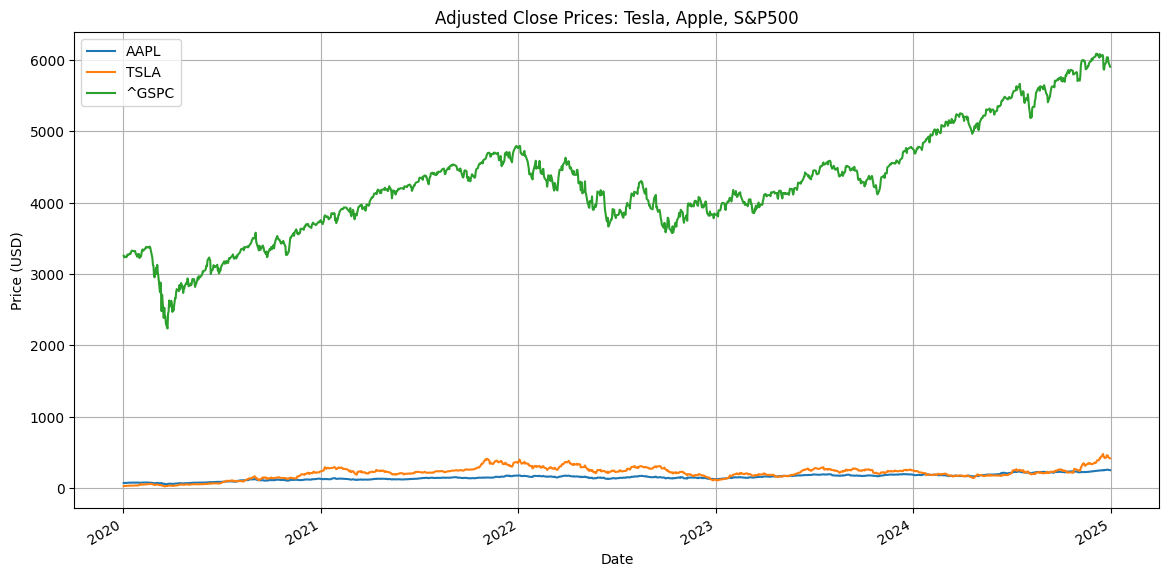

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define ticker symbols
tickers = ['TSLA', 'AAPL', '^GSPC']

# Download data
data = yf.download(tickers, start='2020-01-01', end='2024-12-31')  # Remove ['Adj Close'] for now
# Try to access 'Adj Close', if it fails, use 'Close'
try:
    data = data['Adj Close']
except KeyError:
    data = data['Close']  # Use 'Close' if 'Adj Close' is not found

# Quick look
print(data.head())

# Plot the Adjusted Close Prices
data.plot(figsize=(14, 7))
plt.title('Adjusted Close Prices: Tesla, Apple, S&P500')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

We calculate daily log returns for each of the three

Ticker          AAPL      TSLA     ^GSPC
Date                                    
2020-01-02       NaN       NaN       NaN
2020-01-03 -0.009769  0.029203 -0.007085
2020-01-06  0.007937  0.019072  0.003527
2020-01-07 -0.004714  0.038067 -0.002807
2020-01-08  0.015958  0.048033  0.004890


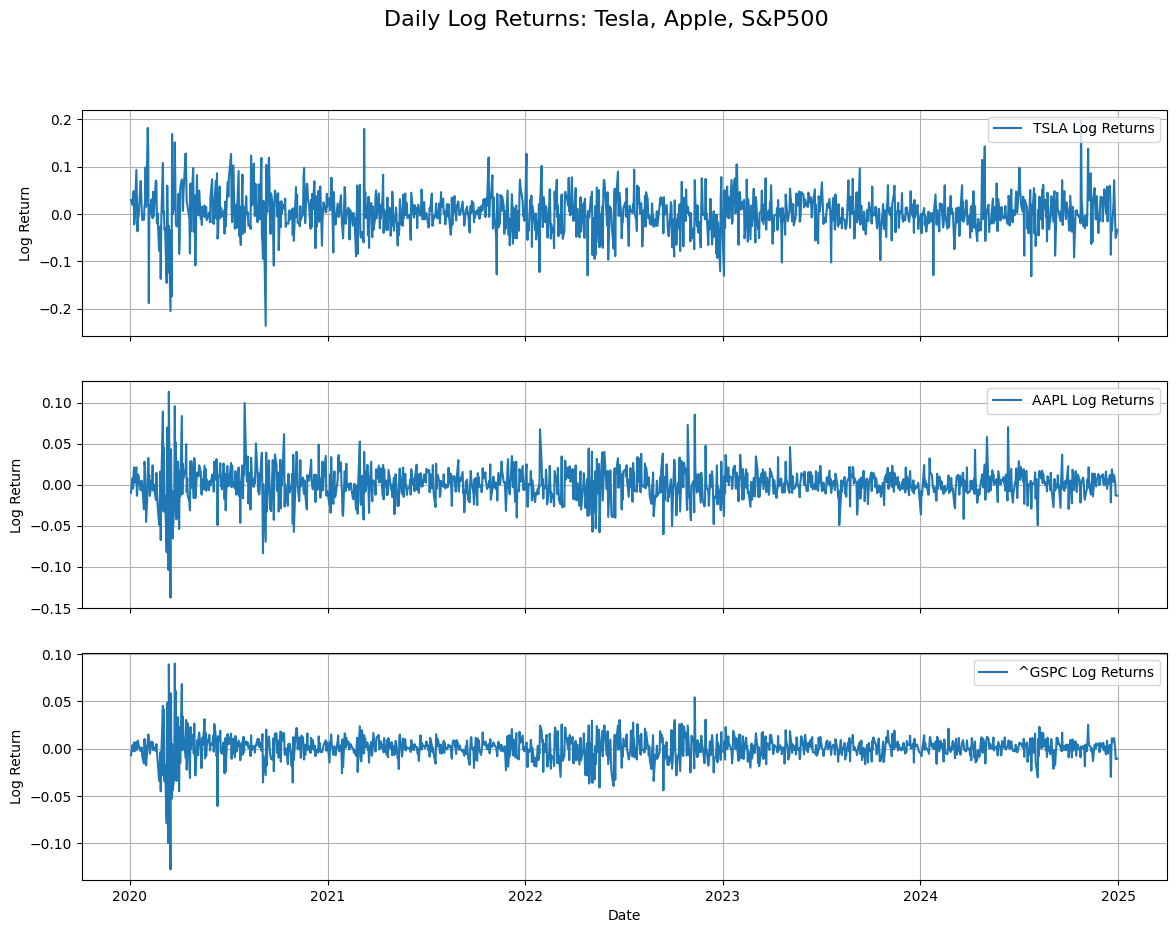

In [4]:
import numpy as np

# Calculate daily log returns
log_returns = np.log(data / data.shift(1))

# Quick look
print(log_returns.head())

# Plot log returns
fig, axs = plt.subplots(3, 1, figsize=(14,10), sharex=True)

for i, ticker in enumerate(tickers):
    axs[i].plot(log_returns.index, log_returns[ticker], label=f'{ticker} Log Returns')
    axs[i].set_ylabel('Log Return')
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

plt.suptitle('Daily Log Returns: Tesla, Apple, S&P500', fontsize=16)
plt.xlabel('Date')
plt.show()


**🛠 Step 3: Fit GARCH(1,1) to All Three Stocks**

In [10]:
from arch import arch_model

# Dictionary to store fitted models
garch_models = {}

# Fit GARCH(1,1) for each stock
for ticker in tickers:
    print(f"\nFitting GARCH(1,1) model for {ticker}...")

    # Drop NaNs (log_returns has NaN at start)
    returns = log_returns[ticker].dropna()

    # Define and fit the model
    model = arch_model(returns, vol='Garch', p=1, q=1, mean='Constant', dist='normal')
    model_fitted = model.fit(disp='off')  # disp='off' to suppress output

    # Save model
    garch_models[ticker] = model_fitted

    # Print a quick model summary
    print(model_fitted.summary())



Fitting GARCH(1,1) model for TSLA...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   TSLA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2254.61
Distribution:                  Normal   AIC:                          -4501.22
Method:            Maximum Likelihood   BIC:                          -4480.68
                                        No. Observations:                 1256
Date:                Sun, Apr 27 2025   Df Residuals:                     1255
Time:                        07:11:05   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.9922

**Quick notes on interpretation:**

1.   If α1 (ARCH term) and β1 (GARCH term) are significant → volatility clustering exists.

2.   If (α1 + β1) ≈ 1 → high persistence of shocks to volatility (bad news lingers).

**🛠 Step 4: Visualize Estimated 📈(In-Sample) Conditional Volatility**

Each fitted GARCH model can give us the conditional volatility at each time point.

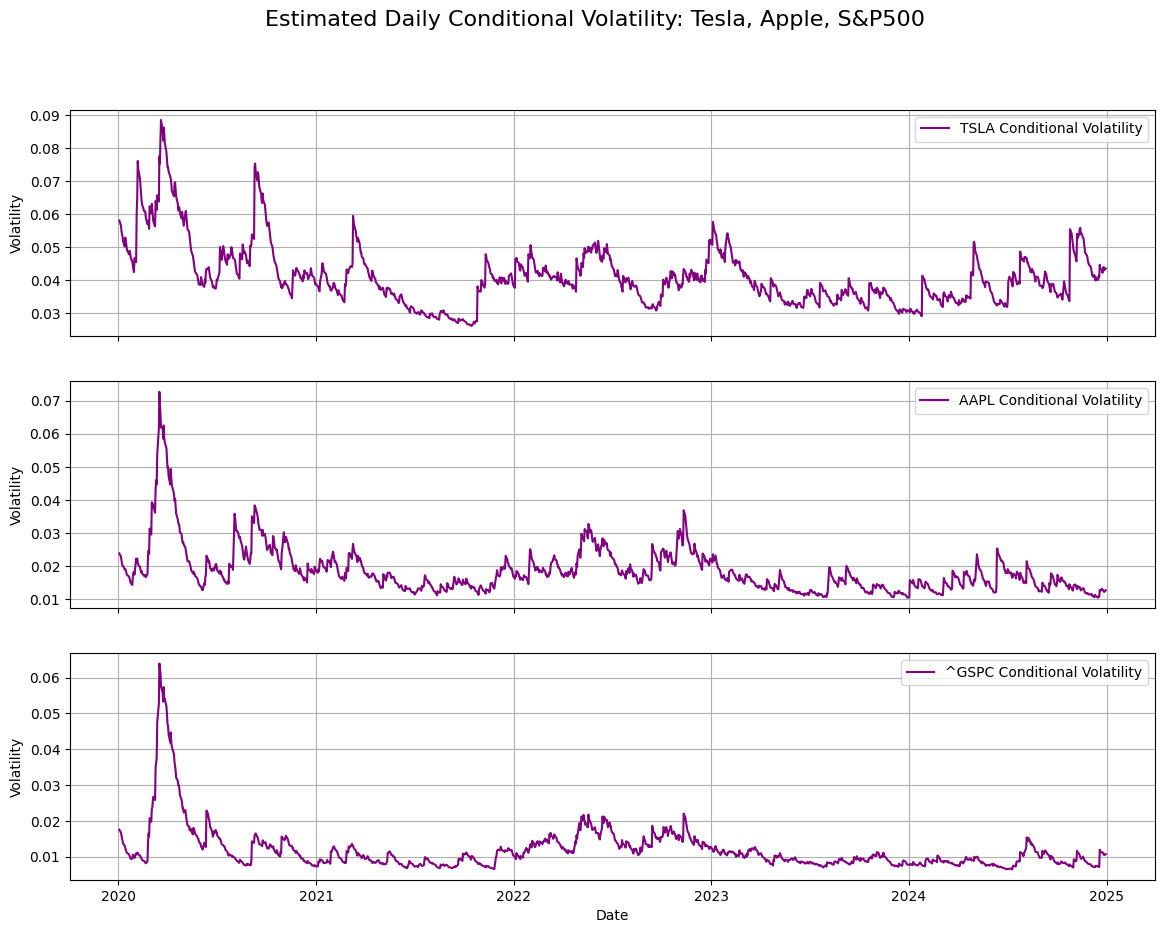

In [12]:
# Plot conditional volatilities
fig, axs = plt.subplots(3, 1, figsize=(14,10), sharex=True)

for i, ticker in enumerate(tickers):
    model_fitted = garch_models[ticker]

    # Conditional Volatility = sqrt of conditional variance
    cond_vol = model_fitted.conditional_volatility

    axs[i].plot(cond_vol.index, cond_vol, label=f'{ticker} Conditional Volatility', color='purple')
    axs[i].set_ylabel('Volatility')
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

plt.suptitle('Estimated Daily Conditional Volatility: Tesla, Apple, S&P500', fontsize=16)
plt.xlabel('Date')
plt.show()


**🛠 Step 5: Forecast Future Volatility (Next 30 Days)**

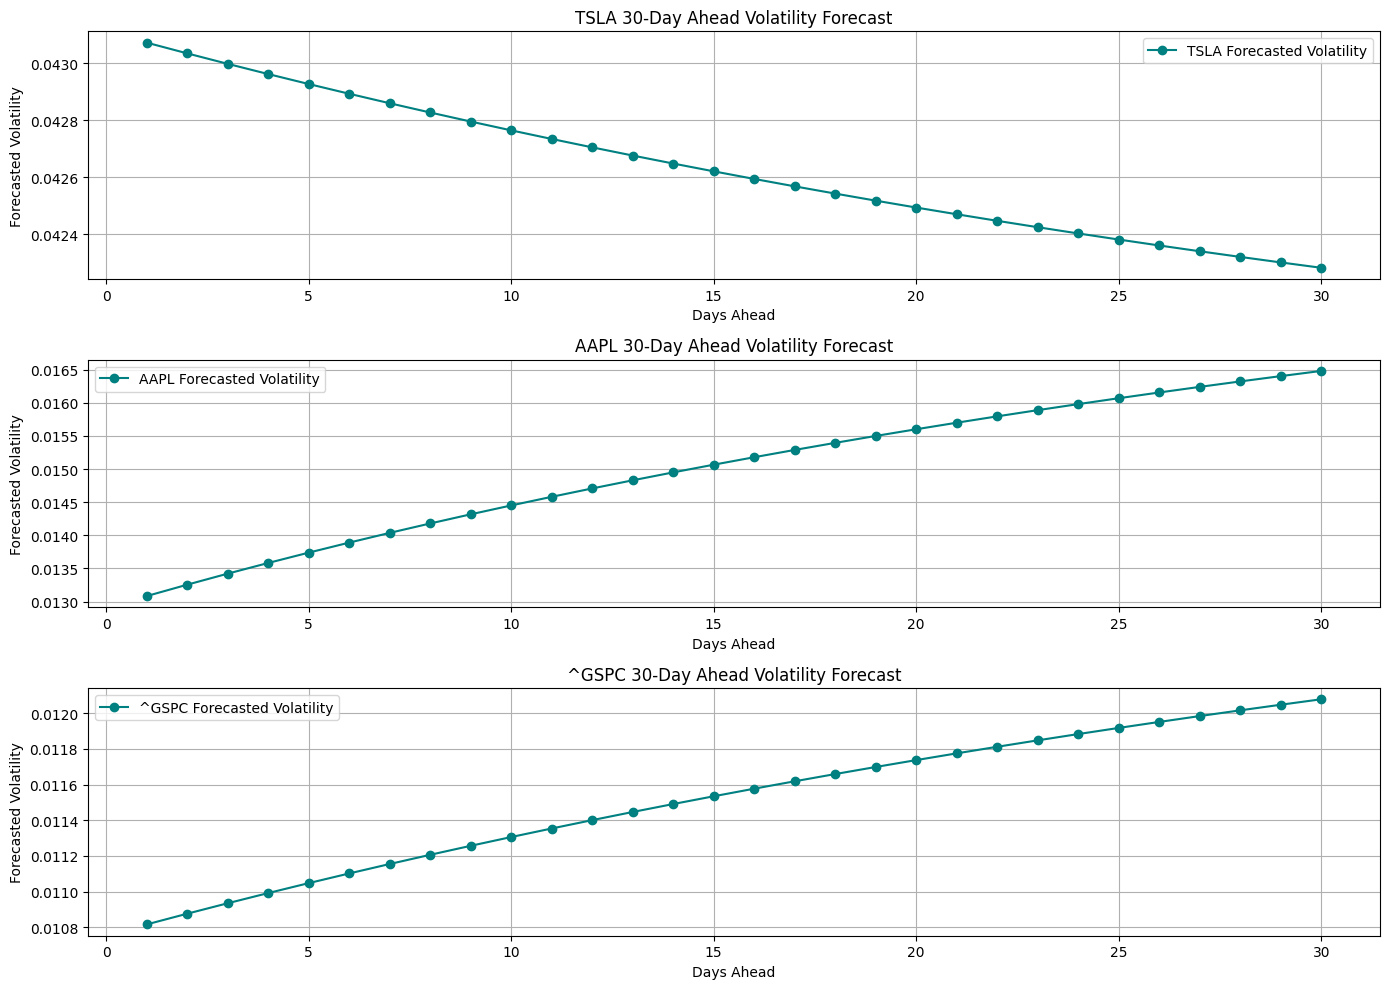

In [13]:
forecast_horizon = 30  # days ahead

# Plot future volatility forecasts
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=False)

for i, ticker in enumerate(tickers):
    model_fitted = garch_models[ticker]

    # Forecast
    forecasts = model_fitted.forecast(horizon=forecast_horizon)

    # Get variance forecasts and take square root for volatility
    fcast_vol = np.sqrt(forecasts.variance.values[-1, :])

    # Plot
    axs[i].plot(range(1, forecast_horizon+1), fcast_vol, marker='o', label=f'{ticker} Forecasted Volatility', color='teal')
    axs[i].set_title(f'{ticker} 30-Day Ahead Volatility Forecast')
    axs[i].set_xlabel('Days Ahead')
    axs[i].set_ylabel('Forecasted Volatility')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()


analysis here

**🛠 Step 6: Fit GJR-GARCH(1,1) Models to All Three Stocks**

We include an additional parameter: γ (gamma) for the asymmetry. o=1 allows the model to capture leverage effects (bad news has a bigger impact on volatility than good news).

In [14]:
# Dictionary to store fitted GJR-GARCH models
gjr_garch_models = {}

# Fit GJR-GARCH(1,1) for each stock
for ticker in tickers:
    print(f"\nFitting GJR-GARCH(1,1) model for {ticker}...")

    returns = log_returns[ticker].dropna()

    # GJR-GARCH model: vol='GARCH', o=1 adds asymmetry
    model = arch_model(returns, vol='GARCH', p=1, o=1, q=1, mean='Constant', dist='normal')
    model_fitted = model.fit(disp='off')

    # Save model
    gjr_garch_models[ticker] = model_fitted

    # Print summary
    print(model_fitted.summary())



Fitting GJR-GARCH(1,1) model for TSLA...
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   TSLA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                2254.64
Distribution:                  Normal   AIC:                          -4499.28
Method:            Maximum Likelihood   BIC:                          -4473.60
                                        No. Observations:                 1256
Date:                Sun, Apr 27 2025   Df Residuals:                     1255
Time:                        07:13:45   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.

When comparing both models, you can look at:

*   AIC/BIC scores (lower is better model fit)

*   Significance of γ (gamma) term (p-value < 0.05 → strong asymmetry)

*   Visual difference in estimated volatilities (are GJR-GARCH volatilities higher after large negative returns?)

*   If GJR-GARCH AIC is lower ➔ asymmetric modeling improved the fit.

*   If gamma is significant ➔ "bad news" indeed hits volatility harder.

In [15]:
for ticker in tickers:
    print(f"\nComparison for {ticker}:")
    print(f"Plain GARCH(1,1) AIC: {garch_models[ticker].aic:.2f}")
    print(f"GJR-GARCH(1,1) AIC: {gjr_garch_models[ticker].aic:.2f}")



Comparison for TSLA:
Plain GARCH(1,1) AIC: -4501.22
GJR-GARCH(1,1) AIC: -4499.28

Comparison for AAPL:
Plain GARCH(1,1) AIC: -6548.61
GJR-GARCH(1,1) AIC: -6558.72

Comparison for ^GSPC:
Plain GARCH(1,1) AIC: -7879.32
GJR-GARCH(1,1) AIC: -7901.85


**🛠 Step 7: Visual Comparison — Tesla (GARCH vs GJR-GARCH)**
*   Blue line: Standard GARCH volatility (symmetric shocks).

*   Red line: GJR-GARCH volatility (accounts for bad-news asymmetry).

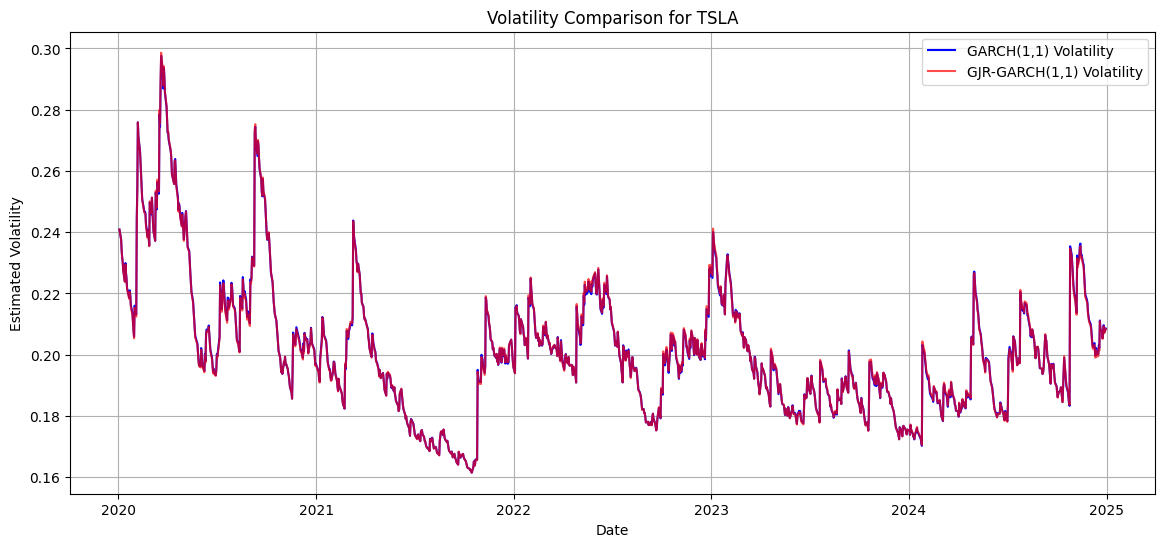

In [16]:
# Choose the stock to visualize
stock = 'TSLA'

# Get returns
returns = log_returns[stock].dropna()

# Get fitted models
garch_fitted = garch_models[stock]
gjr_garch_fitted = gjr_garch_models[stock]

# Get conditional volatilities
garch_vol = np.sqrt(garch_fitted.conditional_volatility)
gjr_garch_vol = np.sqrt(gjr_garch_fitted.conditional_volatility)

# Plot
plt.figure(figsize=(14,6))
plt.plot(returns.index, garch_vol, label='GARCH(1,1) Volatility', color='blue')
plt.plot(returns.index, gjr_garch_vol, label='GJR-GARCH(1,1) Volatility', color='red', alpha=0.7)
plt.title(f'Volatility Comparison for {stock}')
plt.xlabel('Date')
plt.ylabel('Estimated Volatility')
plt.legend()
plt.grid(True)
plt.show()


**We Repeat for All Stocks**

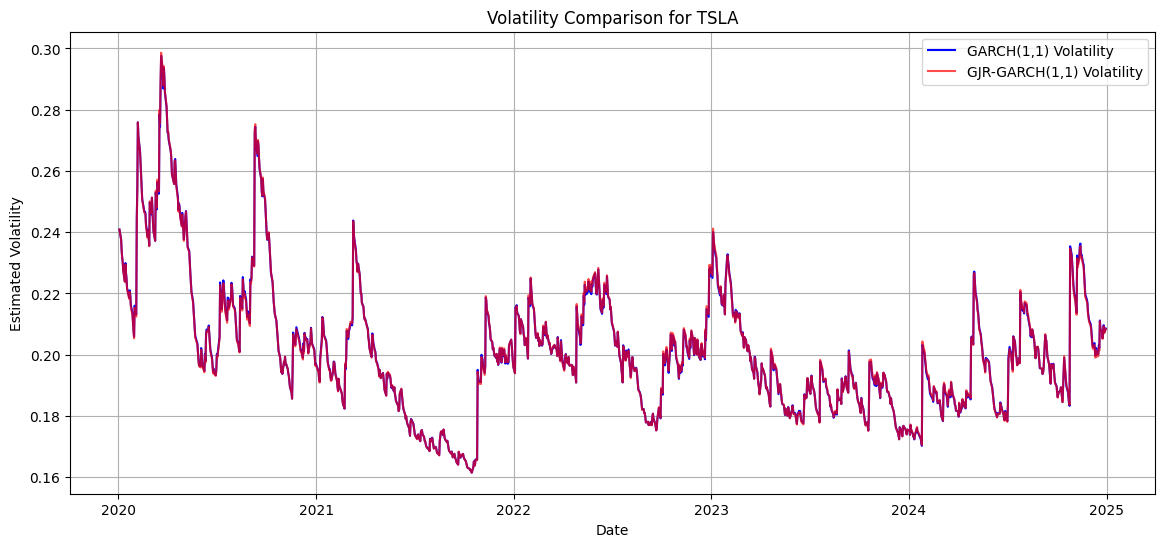

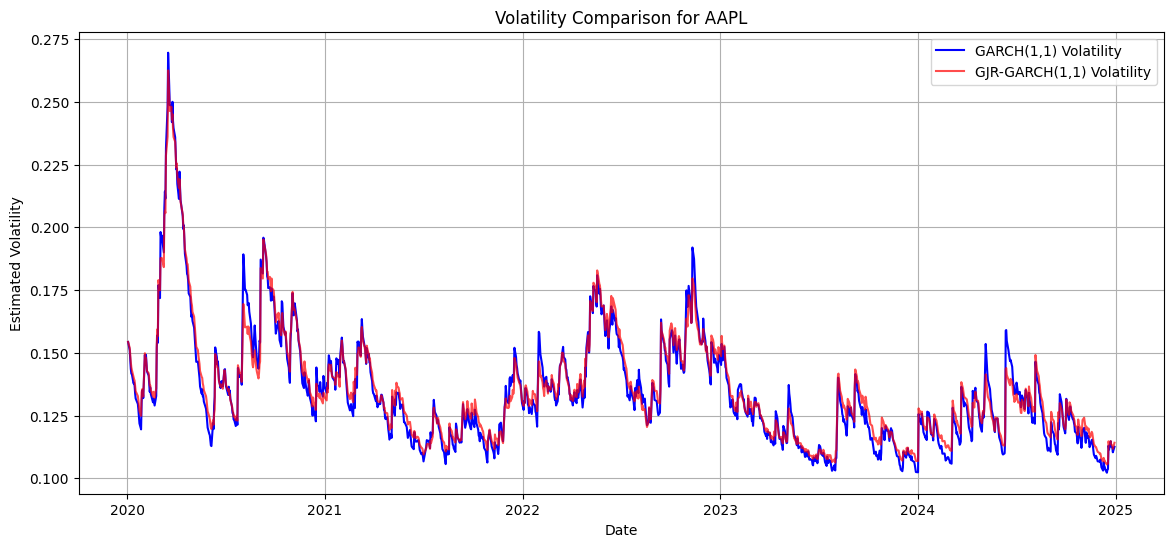

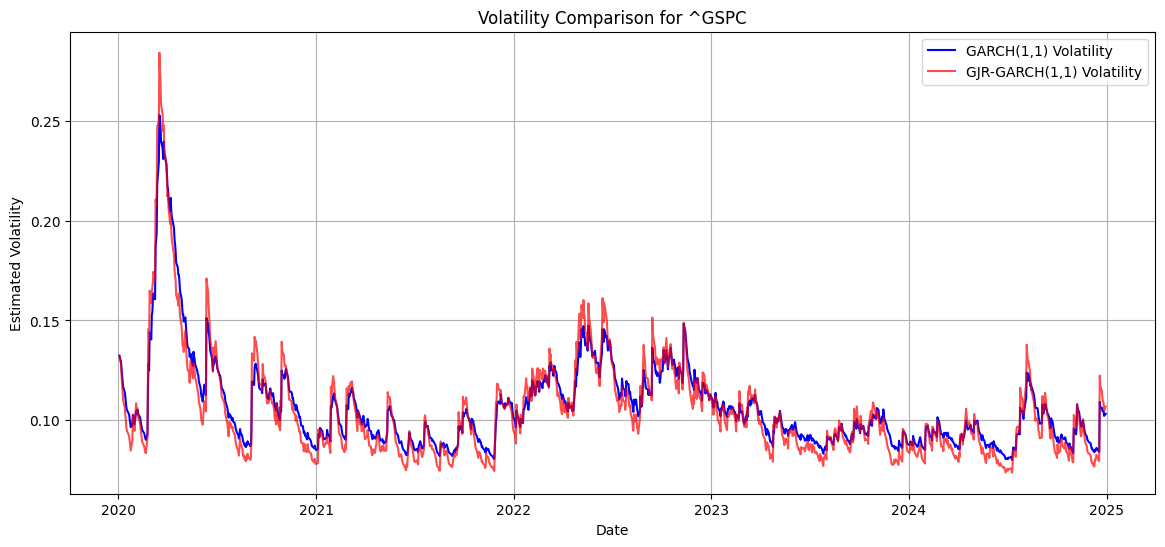

In [17]:
for stock in tickers:
    returns = log_returns[stock].dropna()
    garch_fitted = garch_models[stock]
    gjr_garch_fitted = gjr_garch_models[stock]

    garch_vol = np.sqrt(garch_fitted.conditional_volatility)
    gjr_garch_vol = np.sqrt(gjr_garch_fitted.conditional_volatility)

    plt.figure(figsize=(14,6))
    plt.plot(returns.index, garch_vol, label='GARCH(1,1) Volatility', color='blue')
    plt.plot(returns.index, gjr_garch_vol, label='GJR-GARCH(1,1) Volatility', color='red', alpha=0.7)
    plt.title(f'Volatility Comparison for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Estimated Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()


**🛠 Step 8: Perform Likelihood Ratio (LR) Test**
The idea:

*   Both models are nested (GJR-GARCH adds one extra parameter γ).

*   Null Hypothesis (H₀): GARCH(1,1) is good enough (γ = 0).

*   Alternative (H₁): GJR-GARCH fits better (γ ≠ 0).

We compute:

$$
\text{LR Statistic} = 2 \times \left( \text{LogLik}_{\text{GJR}} - \text{LogLik}_{\text{GARCH}} \right)
$$


and compare it to a chi-squared distribution with 1 degree of freedom.



---


**LR Test for Tesla:**

If p-value < 0.05:

➔   GJR-GARCH is statistically better.

➔   Bad news asymmetry matters for that stock.

If p-value ≥ 0.05:

➔   Simple GARCH(1,1) is good enough.

In [18]:
import scipy.stats as stats

# Choose stock
stock = 'TSLA'

# Log likelihoods
llf_garch = garch_models[stock].loglikelihood
llf_gjr = gjr_garch_models[stock].loglikelihood

# Likelihood Ratio Statistic
lr_stat = 2 * (llf_gjr - llf_garch)

# p-value from chi-square distribution with 1 degree of freedom
p_value = 1 - stats.chi2.cdf(lr_stat, df=1)

print(f"\nLikelihood Ratio Test for {stock}:")
print(f"LR Statistic = {lr_stat:.4f}")
print(f"p-value = {p_value:.4f}")

if p_value < 0.05:
    print("=> GJR-GARCH(1,1) significantly improves the model! ✅")
else:
    print("=> No significant improvement — stick with simple GARCH(1,1).")



Likelihood Ratio Test for TSLA:
LR Statistic = 0.0511
p-value = 0.8212
=> No significant improvement — stick with simple GARCH(1,1).


**LR Test for all the three stocks**

In [19]:
for stock in tickers:
    llf_garch = garch_models[stock].loglikelihood
    llf_gjr = gjr_garch_models[stock].loglikelihood

    lr_stat = 2 * (llf_gjr - llf_garch)
    p_value = 1 - stats.chi2.cdf(lr_stat, df=1)

    print(f"\n{stock} - Likelihood Ratio Test:")
    print(f"LR Statistic = {lr_stat:.4f}")
    print(f"p-value = {p_value:.4f}")

    if p_value < 0.05:
        print("=> GJR-GARCH(1,1) significantly improves the model! ✅")
    else:
        print("=> No significant improvement.")



TSLA - Likelihood Ratio Test:
LR Statistic = 0.0511
p-value = 0.8212
=> No significant improvement.

AAPL - Likelihood Ratio Test:
LR Statistic = 12.1106
p-value = 0.0005
=> GJR-GARCH(1,1) significantly improves the model! ✅

^GSPC - Likelihood Ratio Test:
LR Statistic = 24.5268
p-value = 0.0000
=> GJR-GARCH(1,1) significantly improves the model! ✅


**🛠 Step 9: Professional Summary Results**

We show for each stock:

📉 AIC (GARCH vs GJR-GARCH)

📉 BIC (GARCH vs GJR-GARCH)

📈 LR Statistic

📊 p-value

✅ Which model is better

In [20]:
import pandas as pd

# Create empty list to hold summary
summary_results = []

# Loop over all stocks
for stock in tickers:
    # Extract metrics
    garch_aic = garch_models[stock].aic
    gjr_aic = gjr_garch_models[stock].aic
    garch_bic = garch_models[stock].bic
    gjr_bic = gjr_garch_models[stock].bic

    llf_garch = garch_models[stock].loglikelihood
    llf_gjr = gjr_garch_models[stock].loglikelihood

    lr_stat = 2 * (llf_gjr - llf_garch)
    p_value = 1 - stats.chi2.cdf(lr_stat, df=1)

    better_model = 'GJR-GARCH' if p_value < 0.05 else 'GARCH'

    # Append results
    summary_results.append({
        'Stock': stock,
        'GARCH AIC': round(garch_aic, 2),
        'GJR-GARCH AIC': round(gjr_aic, 2),
        'GARCH BIC': round(garch_bic, 2),
        'GJR-GARCH BIC': round(gjr_bic, 2),
        'LR Stat': round(lr_stat, 4),
        'p-value': round(p_value, 4),
        'Better Model': better_model
    })

# Create DataFrame
results_df = pd.DataFrame(summary_results)

# Display
print("\nFinal Comparison Table:")
print(results_df.to_string(index=False))



Final Comparison Table:
Stock  GARCH AIC  GJR-GARCH AIC  GARCH BIC  GJR-GARCH BIC  LR Stat  p-value Better Model
 TSLA   -4501.22       -4499.28   -4480.68       -4473.60   0.0511   0.8212        GARCH
 AAPL   -6548.61       -6558.72   -6528.07       -6533.05  12.1106   0.0005    GJR-GARCH
^GSPC   -7879.32       -7901.85   -7858.78       -7876.17  24.5268   0.0000    GJR-GARCH


**🛠 Step 10: Forecast Volatility and Simulate Future Stock Paths**

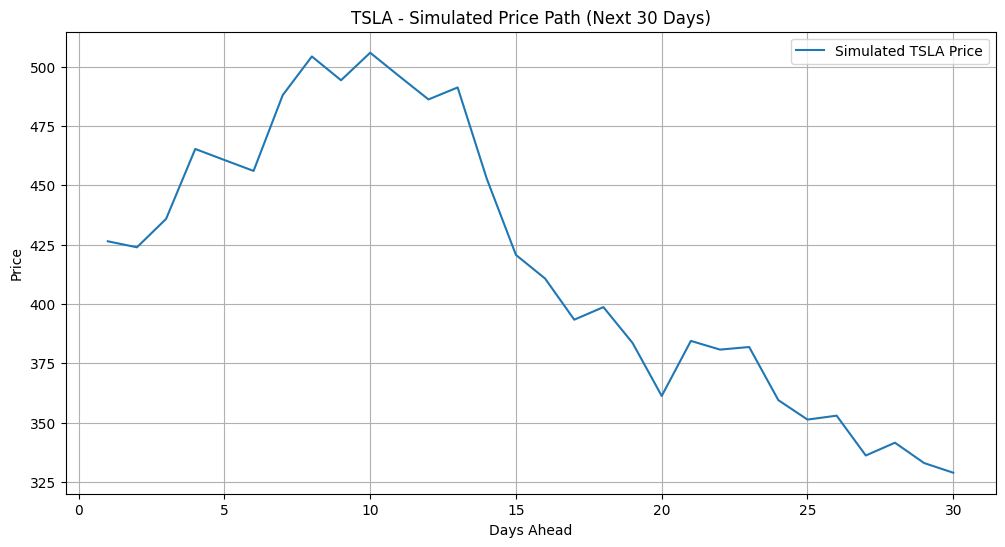

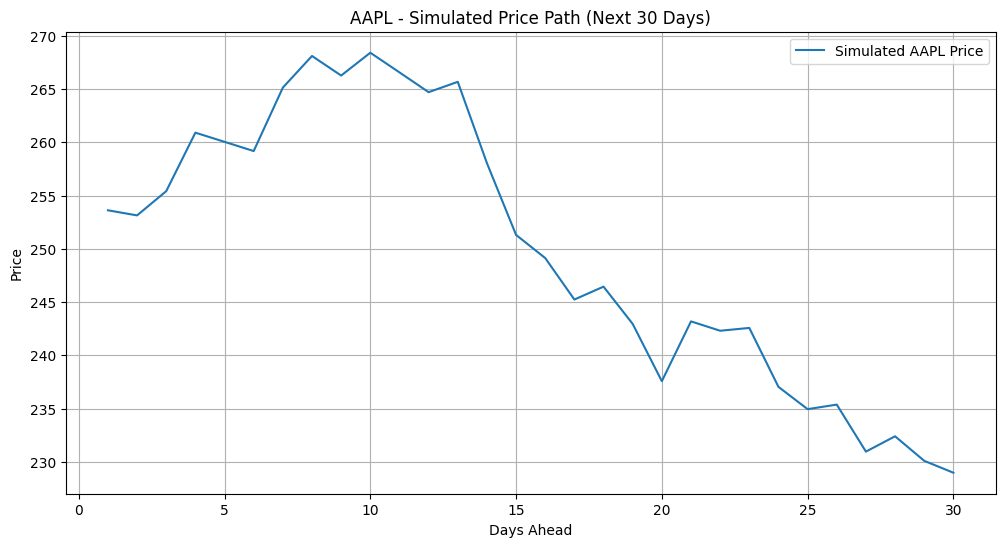

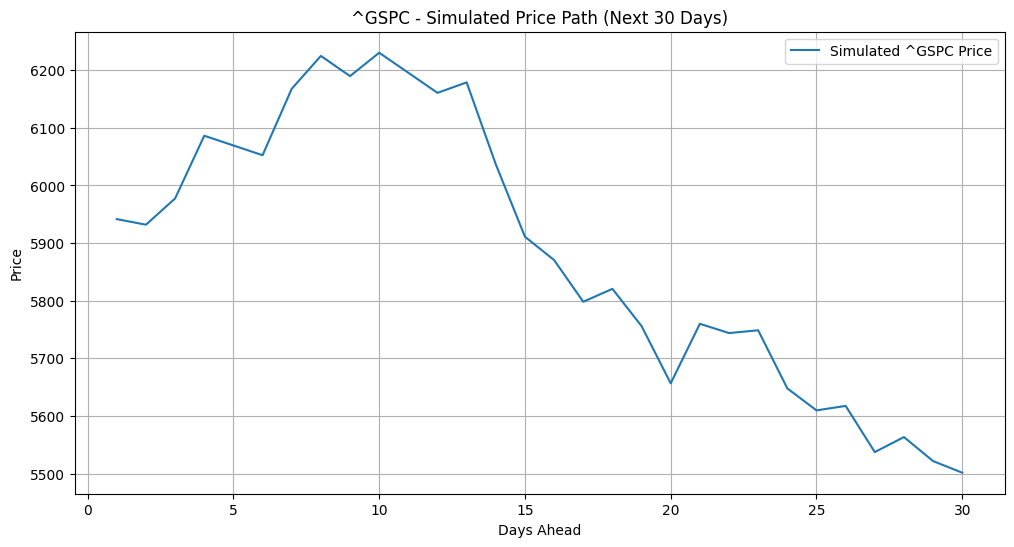

In [22]:
# How many steps into the future to forecast
forecast_days = 30

# Empty dictionary to store forecasts
forecasted_volatility = {}
simulated_prices = {}

# Starting stock prices (✅ fix here)
last_prices = data.iloc[-1]

for stock in tickers:
    # Choose better model
    better_model = gjr_garch_models[stock] if summary_results[tickers.index(stock)]['Better Model'] == 'GJR-GARCH' else garch_models[stock]

    # Forecast future variance
    forecast = better_model.forecast(horizon=forecast_days)
    future_variance = forecast.variance.values[-1, :]
    future_volatility = np.sqrt(future_variance)

    forecasted_volatility[stock] = future_volatility

    # Simulate returns
    np.random.seed(42)  # for reproducibility
    simulated_returns = np.random.normal(0, future_volatility)

    # Simulate prices
    price_paths = last_prices[stock] * np.exp(np.cumsum(simulated_returns))
    simulated_prices[stock] = price_paths

# Plot simulated paths
for stock in tickers:
    plt.figure(figsize=(12,6))
    plt.plot(range(1, forecast_days+1), simulated_prices[stock], label=f'Simulated {stock} Price')
    plt.title(f'{stock} - Simulated Price Path (Next {forecast_days} Days)')
    plt.xlabel('Days Ahead')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()


**🛠 Step 11: Monte Carlo Simulation with Confidence Bands**

For each stock:

*   Simulate 1000 future paths over the next 30 days.

*   Calculate 5th percentile (VaR) and 95th percentile bounds for risk/return.

*   Plot:

   *   Mean path (expected)
   *    5%-95% confidence interval

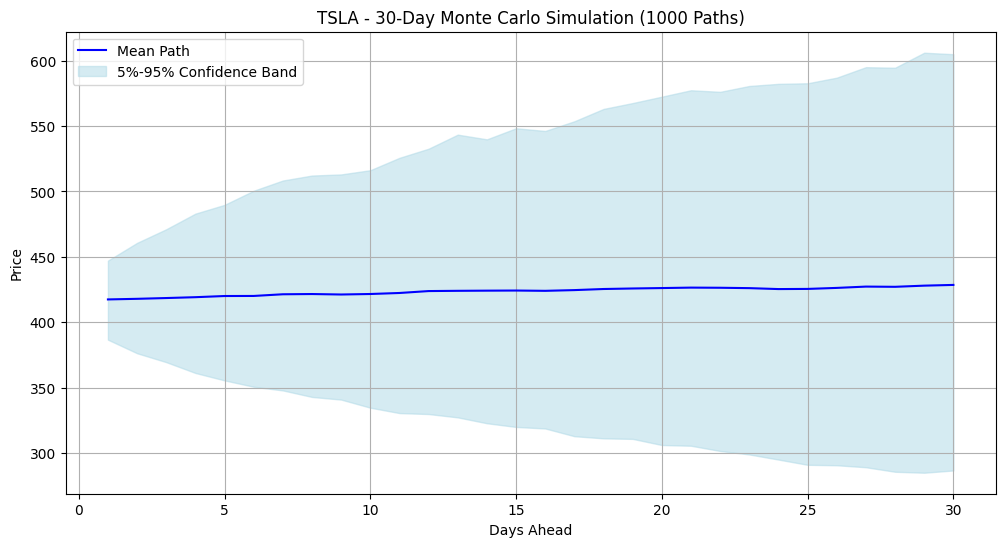

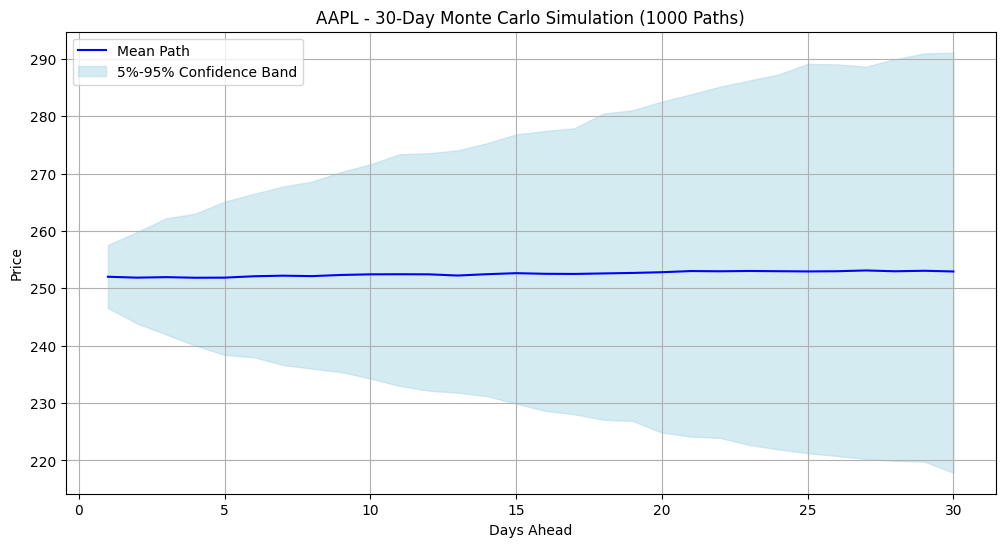

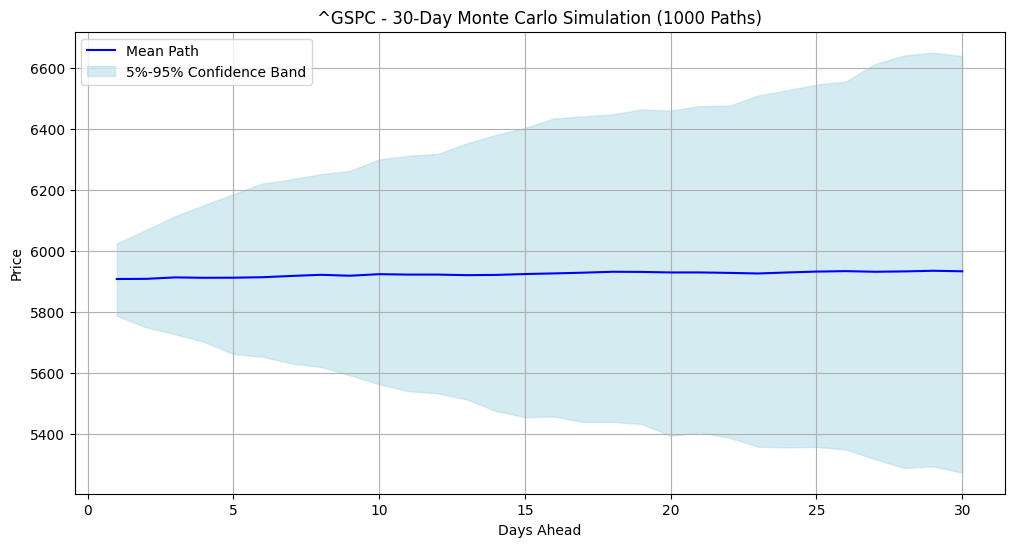

In [23]:
num_simulations = 1000
forecast_days = 30

# Empty dictionaries
mc_simulated_prices = {}

# Starting stock prices (use same 'data' variable)
last_prices = data.iloc[-1]

# Loop over stocks
for stock in tickers:
    # Choose better model
    better_model = gjr_garch_models[stock] if summary_results[tickers.index(stock)]['Better Model'] == 'GJR-GARCH' else garch_models[stock]

    # Forecast future variance
    forecast = better_model.forecast(horizon=forecast_days)
    future_variance = forecast.variance.values[-1, :]
    future_volatility = np.sqrt(future_variance)

    # Monte Carlo Simulations
    simulations = np.zeros((forecast_days, num_simulations))

    for sim in range(num_simulations):
        # Simulate daily returns
        sim_returns = np.random.normal(0, future_volatility)
        # Convert returns to prices
        sim_prices = last_prices[stock] * np.exp(np.cumsum(sim_returns))
        simulations[:, sim] = sim_prices

    mc_simulated_prices[stock] = simulations

# Plot results
for stock in tickers:
    simulations = mc_simulated_prices[stock]

    # Compute mean, 5th and 95th percentiles
    mean_path = np.mean(simulations, axis=1)
    lower_bound = np.percentile(simulations, 5, axis=1)
    upper_bound = np.percentile(simulations, 95, axis=1)

    plt.figure(figsize=(12,6))
    plt.plot(range(1, forecast_days+1), mean_path, label='Mean Path', color='blue')
    plt.fill_between(range(1, forecast_days+1), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='5%-95% Confidence Band')
    plt.title(f'{stock} - 30-Day Monte Carlo Simulation (1000 Paths)')
    plt.xlabel('Days Ahead')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.show()


**🛠 Step 12: Save your fitted models (.pkl) and simulated paths (.csv)**

In [24]:
import pickle
import os

# Create a folder to store models
os.makedirs('saved_models', exist_ok=True)

# Save GARCH models
for stock in tickers:
    with open(f'saved_models/{stock}_garch.pkl', 'wb') as f:
        pickle.dump(garch_models[stock], f)

# Save GJR-GARCH models
for stock in tickers:
    with open(f'saved_models/{stock}_gjr_garch.pkl', 'wb') as f:
        pickle.dump(gjr_garch_models[stock], f)

print("✅ Models saved successfully in 'saved_models/' folder.")


✅ Models saved successfully in 'saved_models/' folder.


In [25]:
# Create folder for simulation outputs
os.makedirs('simulations', exist_ok=True)

# Save each stock's simulations
for stock in tickers:
    sim_df = pd.DataFrame(mc_simulated_prices[stock])
    sim_df.index = range(1, forecast_days + 1)  # Day 1 to Day 30
    sim_df.to_csv(f'simulations/{stock}_mc_simulations.csv')

print("✅ Monte Carlo simulations saved successfully in 'simulations/' folder.")


✅ Monte Carlo simulations saved successfully in 'simulations/' folder.
